### Stock Market Prediction And Forecasting Using Stacked LSTM

#### Steps
- collect the stock data
- preprocess the data - Train and test
- create a n stacked LSTM model
- predict test data and plot the output
- predict future 10 days and plot output

In [2]:
# importing required packages
import quandl
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline

### collect the stock data

In [3]:
# Configuring API key
quandl.ApiConfig.api_key = ("API-KEY")

In [4]:
# We use the get() function to fetch the historical stock price data for sbi
sbi = quandl.get("BSE/BOM500112")
sbi.head()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
Date,,,,,,,,,,,,
1995-05-05,177.0,178.0,174.0,175.0,0.0,0.0,0.0,0.0,NaN,NaN,4.0,-2.0
1995-05-08,172.0,174.0,172.0,172.0,0.0,0.0,0.0,0.0,NaN,NaN,2.0,0.0
1995-05-09,174.0,174.0,170.0,172.0,0.0,0.0,0.0,0.0,NaN,NaN,4.0,-2.0
1995-05-10,171.0,172.0,170.0,171.0,0.0,0.0,0.0,0.0,NaN,NaN,2.0,0.0
1995-05-12,169.0,171.0,167.0,171.0,0.0,0.0,0.0,0.0,NaN,NaN,4.0,2.0


In [5]:
sbi.tail()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
Date,,,,,,,,,,,,
2022-11-03,568.8,587.90,568.80,584.80,581.75,777934.0,15403.0,4.525660e+08,318196.0,40.90,19.10,16.00
2022-11-04,586.0,596.75,580.60,593.75,587.88,797243.0,12564.0,4.686870e+08,282169.0,35.39,16.15,7.75
2022-11-07,614.0,622.90,607.85,614.20,616.17,1680075.0,27538.0,1.035208e+09,542751.0,32.31,15.05,0.20
2022-11-09,620.0,620.55,610.70,615.55,615.34,935161.0,18761.0,5.754445e+08,326973.0,34.96,9.85,-4.45
2022-11-10,610.1,615.00,602.20,605.70,607.25,605727.0,14367.0,3.678298e+08,204282.0,33.72,12.80,-4.40


In [10]:
# as we are oly interested in closing price we only keep date and close price columns\
df_sbi = sbi.reset_index()['Close']
df_sbi

0       175.00
1       172.00
2       172.00
3       171.00
4       171.00
         ...  
6810    584.80
6811    593.75
6812    614.20
6813    615.55
6814    605.70
Name: Close, Length: 6815, dtype: float64

### Preprocess the data

In [11]:
print("Shape of data ", df_sbi.shape)

Shape of data  (6815,)


In [12]:
df_sbi.isnull().sum()

0

<AxesSubplot:>

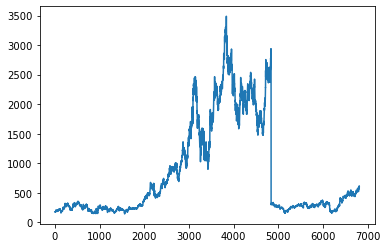

In [13]:
## the data looks seasonal
df_sbi.plot()

In [14]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df_sbi=scaler.fit_transform(np.array(df_sbi).reshape(-1,1))

In [15]:
df_sbi

array([[0.01028665],
       [0.00939086],
       [0.00939086],
       ...,
       [0.14143028],
       [0.14183338],
       [0.13889221]])

### Train and test split

In [17]:
##splitting dataset into train and test split
training_size=int(len(df_sbi)*0.7)  #70
test_size=len(df_sbi)-training_size  #30
train_data,test_data=df_sbi[0:training_size,:],df_sbi[training_size:len(df_sbi),:1]

In [18]:
training_size,test_size

(4770, 2045)

In [21]:
# shows train data
# train_data

In [26]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [27]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [28]:
print(X_train.shape), print(y_train.shape)

(4669, 100)
(4669,)


(None, None)

In [29]:
print(X_test.shape), print(ytest.shape)

(1944, 100)
(1944,)


(None, None)

In [30]:
# reshape input to be [samples, time steps, features] which is required for LSTM(3-dimensions)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### create an stacked LSTM model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [32]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
73/73 [==============================] - 19s 169ms/step - loss: 0.0080 - val_loss: 4.2686e-05
Epoch 2/100
73/73 [==============================] - 9s 127ms/step - loss: 7.9759e-04 - val_loss: 3.7027e-05
Epoch 3/100
73/73 [==============================] - 10s 135ms/step - loss: 6.9344e-04 - val_loss: 3.4716e-05
Epoch 4/100
73/73 [==============================] - 11s 145ms/step - loss: 5.9793e-04 - val_loss: 4.0425e-05
Epoch 5/100
73/73 [==============================] - 11s 150ms/step - loss: 5.4287e-04 - val_loss: 3.1375e-05
Epoch 6/100
73/73 [==============================] - 11s 149ms/step - loss: 5.0102e-04 - val_loss: 3.1614e-05
Epoch 7/100
73/73 [==============================] - 11s 145ms/step - loss: 4.7862e-04 - val_loss: 2.6398e-05
Epoch 8/100
73/73 [==============================] - 9s 130ms/step - loss: 4.2793e-04 - val_loss: 2.5239e-05
Epoch 9/100
73/73 [==============================] - 9s 125ms/step - loss: 5.1867e-04 - val_loss: 2.8222e-05
Epoch 10/100
73/7

73/73 [==============================] - 9s 126ms/step - loss: 1.0190e-04 - val_loss: 9.6780e-06
Epoch 76/100
73/73 [==============================] - 9s 126ms/step - loss: 1.0835e-04 - val_loss: 6.8111e-06
Epoch 77/100
73/73 [==============================] - 9s 127ms/step - loss: 9.8928e-05 - val_loss: 6.6208e-06
Epoch 78/100
73/73 [==============================] - 9s 126ms/step - loss: 9.8140e-05 - val_loss: 6.2226e-06
Epoch 79/100
73/73 [==============================] - 9s 127ms/step - loss: 9.8231e-05 - val_loss: 1.0831e-05
Epoch 80/100
73/73 [==============================] - 9s 127ms/step - loss: 9.0239e-05 - val_loss: 6.0509e-06
Epoch 81/100
73/73 [==============================] - 9s 127ms/step - loss: 9.4724e-05 - val_loss: 6.3180e-06
Epoch 82/100
73/73 [==============================] - 9s 128ms/step - loss: 1.0129e-04 - val_loss: 5.9993e-06
Epoch 83/100
73/73 [==============================] - 9s 130ms/step - loss: 1.0838e-04 - val_loss: 8.0868e-06
Epoch 84/100
73/73 [===

In [35]:
import tensorflow as tf

In [36]:
# tf.__version__

### predict test data and plot the output

In [37]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

61/61 [==============================] - 1s 24ms/step


In [38]:
# Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [39]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

1335.7972671794362

In [40]:
# Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

316.33200135953814

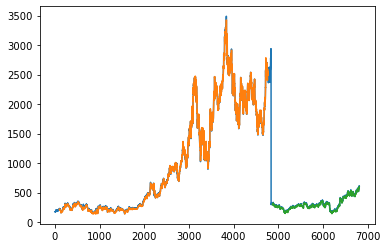

In [41]:
# Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df_sbi)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_sbi)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_sbi)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_sbi))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

- In Above plot:
    - Blue ---> complete dataset
    - orange ---> training data predicted output
    - Green ---> Test data predicted output

In [43]:
len(test_data)

2045

In [44]:
x_input=test_data[1945:].reshape(1,-1)
x_input.shape


(1, 100)

In [45]:
# converting input data to list
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [48]:
# temp_input

### Predict future 10 days and plot output

In [49]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<10):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.13938296]
101
1 day input [0.08971335 0.08769782 0.09260973 0.09171394 0.09280382 0.09369961
 0.095745   0.09668558 0.09522245 0.09711854 0.097447   0.09940281
 0.09901463 0.10125411 0.10337414 0.10388176 0.10380711 0.10279188
 0.10334428 0.10119439 0.10106002 0.10441923 0.10673335 0.10989848
 0.11092864 0.11142132 0.11258585 0.11155569 0.11579576 0.11697522
 0.11575097 0.11736339 0.11982681 0.11951329 0.11715437 0.11648253
 0.11339206 0.1116602  0.11466109 0.11648253 0.1150642  0.11569125
 0.11700508 0.11342192 0.11067483 0.1139146  0.11304867 0.11346671
 0.11443715 0.11171992 0.11663183 0.11727381 0.11821439 0.11896088
 0.11860257 0.11707973 0.12067781 0.12329053 0.12370857 0.1247238
 0.12871006 0.12887429 0.1257241  0.12894894 0.12945655 0.12817259
 0.12745596 0.12239474 0.12040908 0.11815467 0.11488504 0.11388474
 0.11660197 0.11319797 0.11709466 0.11845327 0.11639295 0.11637802
 0.11545237 0.1174679  0.11370558 0.11540758 0.12043894 0.1259779
 0.12321589 0.1238728  0.12548522 0

8 day output [[0.1338685]]
9 day input [0.09522245 0.09711854 0.097447   0.09940281 0.09901463 0.10125411
 0.10337414 0.10388176 0.10380711 0.10279188 0.10334428 0.10119439
 0.10106002 0.10441923 0.10673335 0.10989848 0.11092864 0.11142132
 0.11258585 0.11155569 0.11579576 0.11697522 0.11575097 0.11736339
 0.11982681 0.11951329 0.11715437 0.11648253 0.11339206 0.1116602
 0.11466109 0.11648253 0.1150642  0.11569125 0.11700508 0.11342192
 0.11067483 0.1139146  0.11304867 0.11346671 0.11443715 0.11171992
 0.11663183 0.11727381 0.11821439 0.11896088 0.11860257 0.11707973
 0.12067781 0.12329053 0.12370857 0.1247238  0.12871006 0.12887429
 0.1257241  0.12894894 0.12945655 0.12817259 0.12745596 0.12239474
 0.12040908 0.11815467 0.11488504 0.11388474 0.11660197 0.11319797
 0.11709466 0.11845327 0.11639295 0.11637802 0.11545237 0.1174679
 0.11370558 0.11540758 0.12043894 0.1259779  0.12321589 0.1238728
 0.12548522 0.12833682 0.13066587 0.13108391 0.12845626 0.12936698
 0.13024784 0.12941176 0.1

In [50]:
day_new=np.arange(1,101)
day_pred=np.arange(101,111)

In [51]:
import matplotlib.pyplot as plt

In [54]:
len(df_sbi)

6815

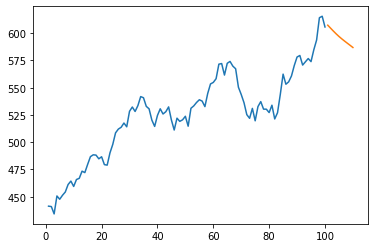

In [56]:
# plotting next 10 days prediction
plt.plot(day_new,scaler.inverse_transform(df_sbi[6715:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

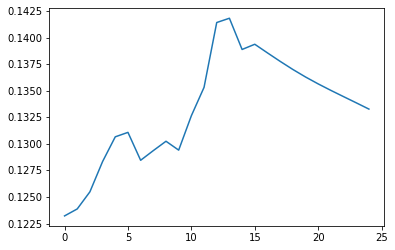

In [62]:
# combining prediction with original df 
# to see the clear prediction plot
df2_sbi=df_sbi.tolist()
df2_sbi.extend(lst_output)
plt.plot(df2_sbi[6800:])

In [63]:
df2_sbi=scaler.inverse_transform(df2_sbi).tolist()

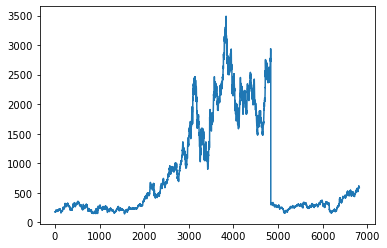

In [64]:
plt.plot(df2_sbi)

### Improvements can be:
- for increasing accuracy increase the timesteps value 
- try to predict for next 100 days and see the output
- use bidirectional LSTM for more accuracy